In [15]:
import torch
import torch.nn as nn  
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
 

In [16]:
import os
print(os.getcwd())  # This will show the directory where the script is being executed


/home/arnavbhatt/arnav/GITHUB/GANS


In [17]:
# Transforming the dataset
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder(root="../celeb_a_dataset", transform = transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)



In [18]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, feature_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            # Input is of shape N x (input_channels) x 64 x 64
            nn.Conv2d(input_dim, feature_dim, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim, feature_dim * 2, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(feature_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim * 2, feature_dim * 4, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(feature_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim * 4, feature_dim * 8, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(feature_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_dim * 8, 1, kernel_size=4, stride=1, padding=0),  # 1x1
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, x):
        return self.model(x)

In [19]:
# Testing the Discriminator class
example = torch.randn((10,3,64,64))
D = Discriminator(3,64)
print(D(example).shape)

torch.Size([10, 1, 1, 1])


In [20]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, output_channels, feature_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            # Input is of shape N x (latent_dim) x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_dim * 16, kernel_size=4, stride=1, padding=0),  # 4x4
            nn.BatchNorm2d(feature_dim * 16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_dim * 16, feature_dim * 8, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(feature_dim * 8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(feature_dim * 4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(feature_dim * 2),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_dim * 2, output_channels, kernel_size=4, stride=2, padding=1),  # 64 x 64
            nn.Tanh()  # Output is of range [-1, 1]
        )
    
    def forward(self, x):
        return self.model(x)

In [21]:
# Testing the Generator class
example = torch.randn((10, 100, 1, 1))
G = Generator(100, 3, 64)
print(G(example).shape)

torch.Size([10, 3, 64, 64])


In [22]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.xavier_normal_(m.weight.data)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
            nn.init.constant_(m.bias.data, 0)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
output_channels = 3
feature_dim = 64
batch_size = 64

G = Generator(latent_dim, output_channels, feature_dim).to(device)
D = Discriminator(output_channels, feature_dim).to(device)
initialize_weights(G)
initialize_weights(D)

D_loss = []
G_loss = []

lr_D = 5e-5
lr_G = 5e-5

D_optimizer = optim.Adam(D.parameters(), lr=lr_D, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr_G, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [ ]:
epochs = 15
n_generator = 1
n_discriminator = 1

for epoch in tqdm(range(epochs)):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Training the Discriminator
        for d in range(n_discriminator):
            latent_vector = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            fake_images = G(latent_vector).detach()       # Detach to prevent generator gradients getting updated

            disc_real = D(real_images).squeeze()
            disc_fake = D(fake_images.detach()).squeeze()  

            D_loss_real = -torch.log(disc_real + 1e-9)
            D_loss_fake = -torch.log(1 - disc_fake + 1e-9)
            loss_D = D_loss_real.mean() + D_loss_fake.mean()

            D_optimizer.zero_grad()
            loss_D.backward()
            D_optimizer.step()

        # Appending discriminator loss
        D_loss.append(loss_D.item())

        # Training the Generator
        for g in range(n_generator):
            latent_vector = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            fake_images = G(latent_vector)

            disc_fake = D(fake_images).squeeze()
            loss_G = -torch.log(disc_fake + 1e-9).mean()

            G_optimizer.zero_grad()
            loss_G.backward()
            G_optimizer.step()

        # Appending generator loss
        G_loss.append(loss_G.item())


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(D_loss, label='Discriminator Loss')
plt.plot(G_loss, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


In [68]:
# saving weights 
torch.save(G.state_dict(), "generator_final.pth")
torch.save(D.state_dict(), "discriminator_final.pth")

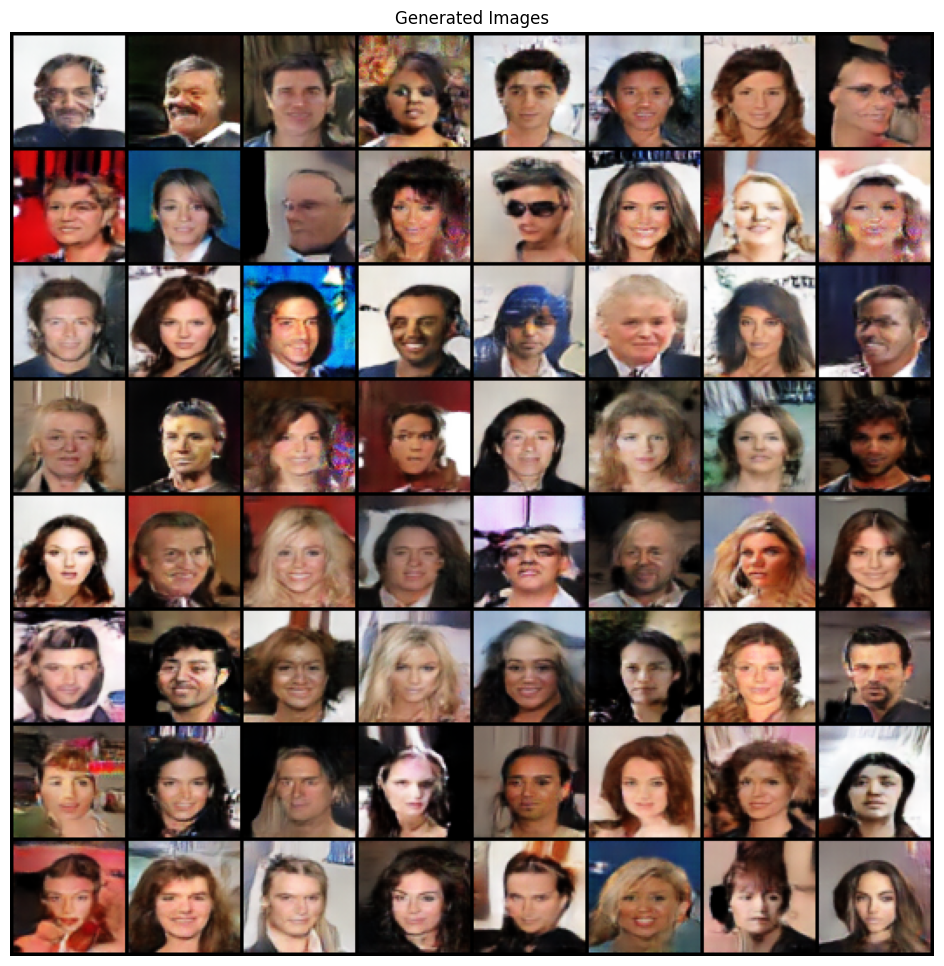

In [27]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to generate and visualize images
def generate_images(generator, latent_dim, num_images, device, save_path=None):
    # Set the generator to evaluation mode
    generator.eval()

    # Generate random noise vectors
    noise = torch.randn((num_images, latent_dim, 1, 1), device=device)

    # Generate fake images
    with torch.no_grad():  # No need to calculate gradients
        fake_images = generator(noise)

    # Normalize the images to [0, 1] for visualization
    fake_images = (fake_images + 1) / 2  # Since the generator outputs images in range [-1, 1]

    # Create a grid of images
    grid = vutils.make_grid(fake_images, nrow=8, normalize=True)

    # Visualize the images
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu())  # Convert CHW to HWC for visualization
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()

    
# Example usage
latent_dim = 100
num_images = 64
generate_images(G, latent_dim, num_images, device, save_path="generated_images.png")
